In [1]:
import os, certifi

os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = os.environ["SSL_CERT_FILE"]

import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [3]:
# Baseline hyperparameters
latent_dim = 100
hidden_dim = 64
image_size = 28 # MNIST 28x28
batch_size = 128
lr_g = 2e-4
lr_d = 2e-4

beta1, beta2 = 0.5, 0.999
num_epochs = 30

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

len(train_dataset), len(train_loader)

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 226kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.95MB/s]


(60000, 468)

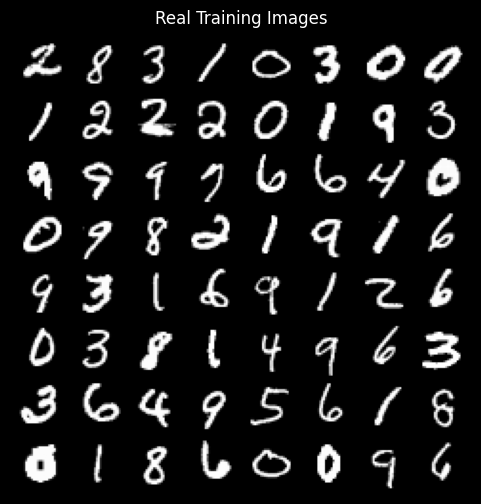

In [4]:
# Visualizing some real samples
real_batch = next(iter(train_loader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Real Training Images")
plt.imshow(
    utils.make_grid(real_batch[0][:64], padding=2, normalize=True)
    .cpu()
    .permute(1, 2, 0)
)
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=64, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, hidden_dim * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            # state size. (hidden_dim*4) x 4 x 4
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # state size. (hidden_dim*2) x 7 x 7
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # state size. (hidden_dim) x 14 x 14
            nn.ConvTranspose2d(hidden_dim, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (img_channels) x 28 x 28
        )

    def forward(self, z):
        # z: (batch_size, latent_dim) -> (batch_size, latent_dim, 1, 1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            # input is (img_channels) x 28 x 28
            nn.Conv2d(img_channels, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim) x 14 x 14
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*2) x 7 x 7
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*4) x 4 x 4
            nn.Conv2d(hidden_dim * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(latent_dim=latent_dim, hidden_dim=hidden_dim, img_channels=1).to(device)
D = Discriminator(img_channels=1, hidden_dim=hidden_dim).to(device)

G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(
    G.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

optimizer_D = optim.Adam(
    D.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

In [7]:
#Visualizing generated samples helper
def show_fake_samples(epoch, fixed_noise, nrow=8):
    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise.to(device))
    G.train()
    fake = (fake + 1) / 2.0  # back to [0, 1] for display
    grid = utils.make_grid(fake, nrow=nrow)
    plt.figure(figsize=(6, 6))
    plt.title(f"Generated samples at epoch {epoch}")
    plt.axis('off')
    plt.imshow(grid.cpu().permute(1, 2, 0).squeeze())
    plt.show()


fixed_noise = torch.randn(64, latent_dim, device=device)

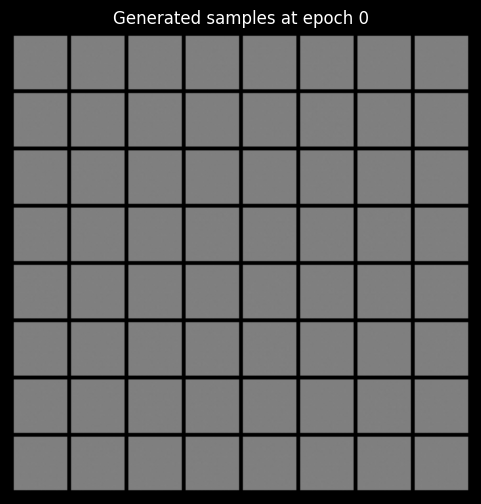

In [8]:
show_fake_samples(0, fixed_noise)

Epoch [1/30]  D_loss: 0.1242  G_loss: 4.3554


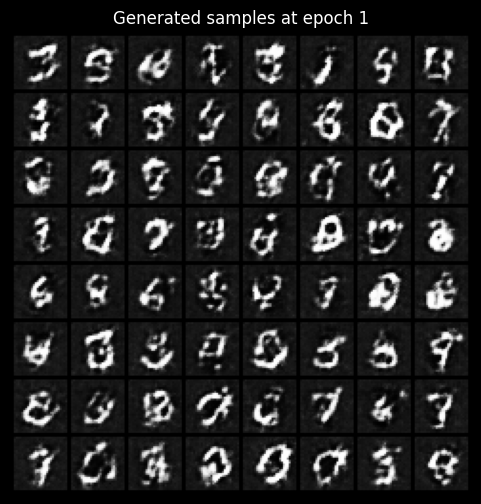

Epoch [2/30]  D_loss: 0.2949  G_loss: 2.3060


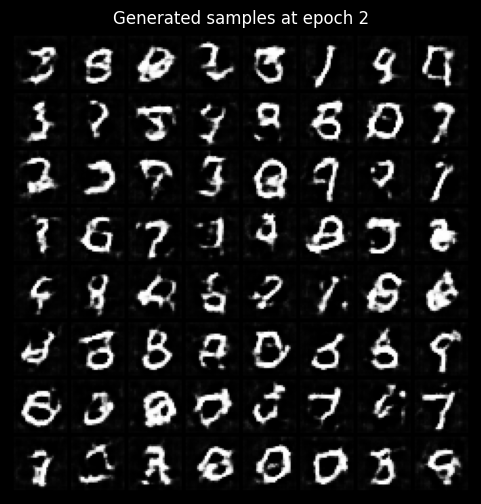

Epoch [3/30]  D_loss: 0.4984  G_loss: 1.4687


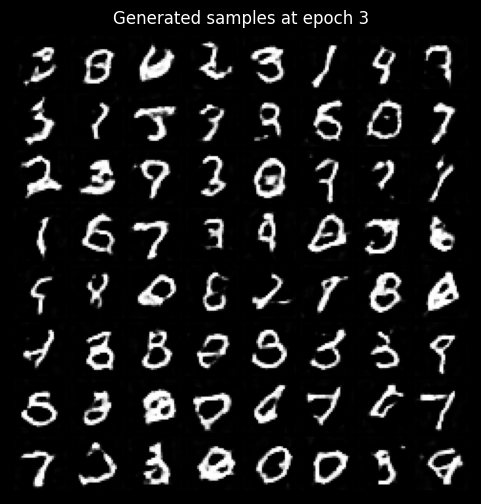

Epoch [4/30]  D_loss: 0.4263  G_loss: 2.6030


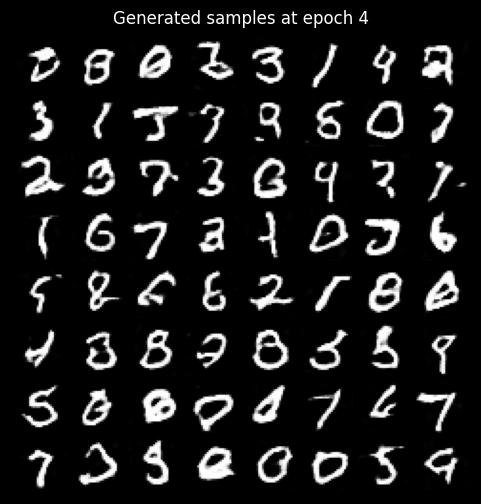

Epoch [5/30]  D_loss: 0.4128  G_loss: 2.0776


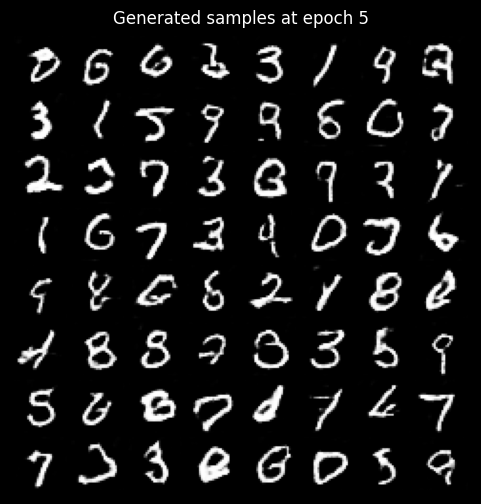

Epoch [6/30]  D_loss: 1.1092  G_loss: 1.2013


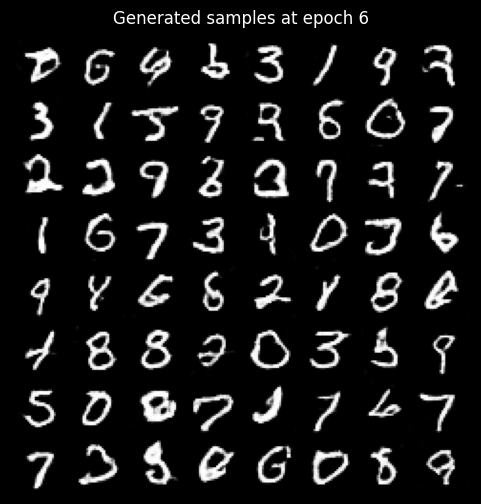

Epoch [7/30]  D_loss: 0.5792  G_loss: 2.0768


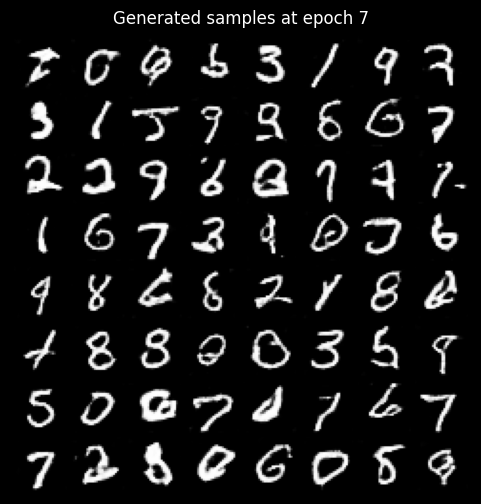

Epoch [8/30]  D_loss: 0.3036  G_loss: 2.3930


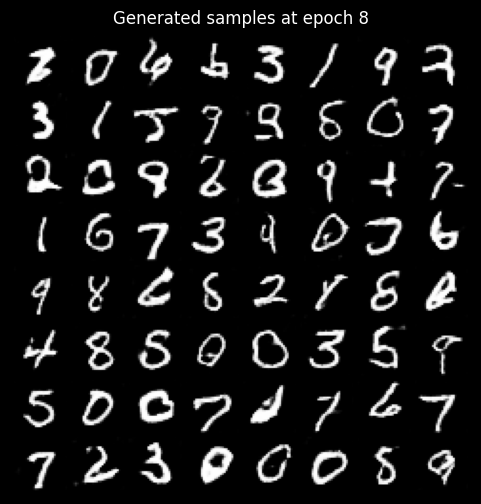

Epoch [9/30]  D_loss: 0.3281  G_loss: 1.7608


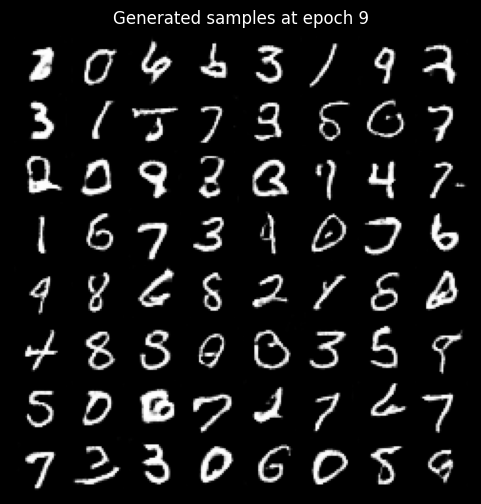

Epoch [10/30]  D_loss: 2.7952  G_loss: 3.4462


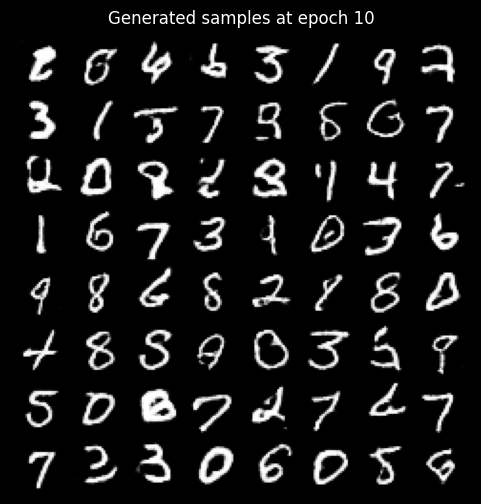

Epoch [11/30]  D_loss: 0.3034  G_loss: 2.9776


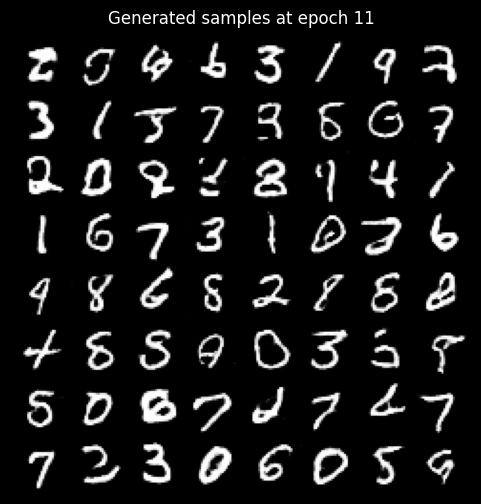

Epoch [12/30]  D_loss: 0.2850  G_loss: 3.5070


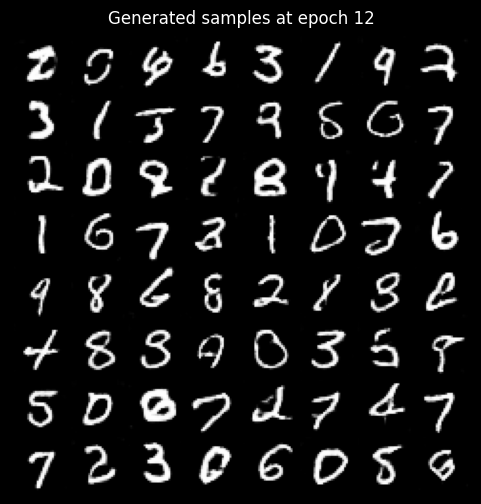

Epoch [13/30]  D_loss: 0.2738  G_loss: 2.6096


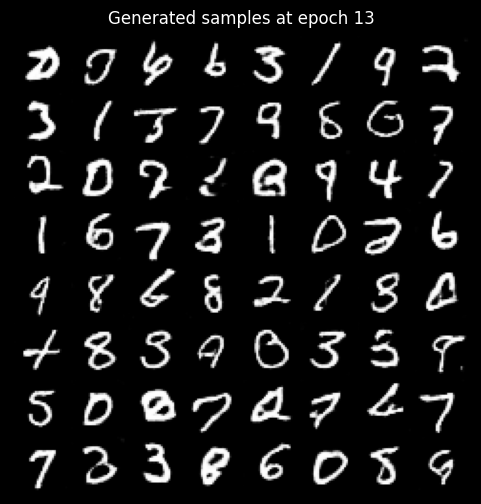

Epoch [14/30]  D_loss: 0.2242  G_loss: 2.0618


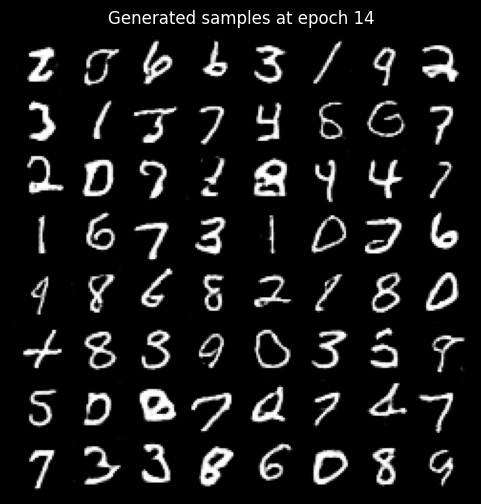

Epoch [15/30]  D_loss: 0.2557  G_loss: 2.5884


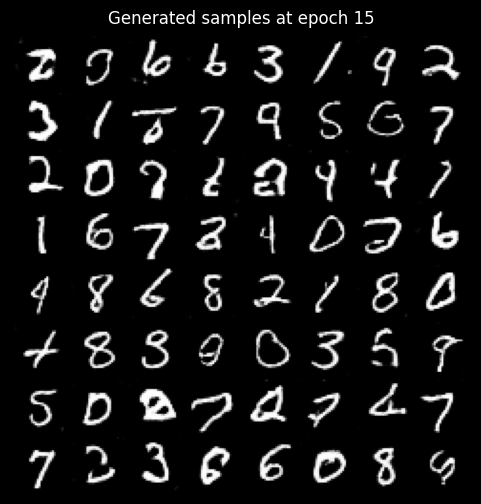

Epoch [16/30]  D_loss: 0.3524  G_loss: 4.3729


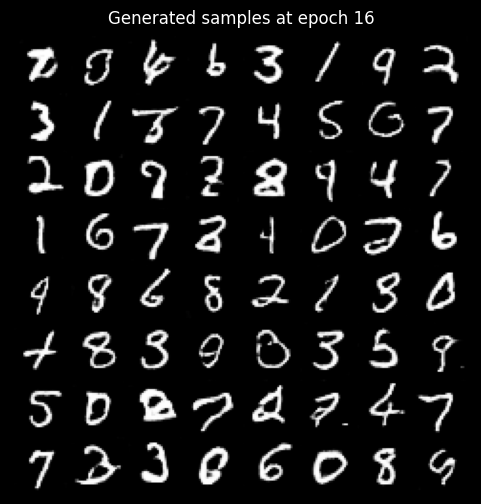

Epoch [17/30]  D_loss: 0.4124  G_loss: 2.5493


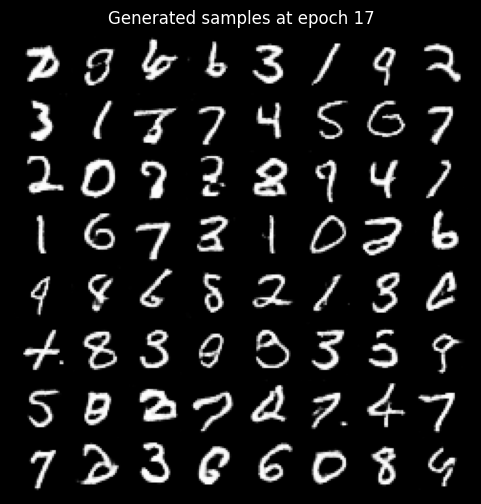

Epoch [18/30]  D_loss: 0.2655  G_loss: 3.1086


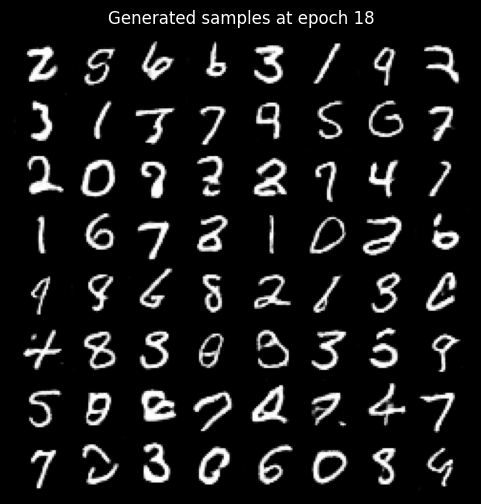

Epoch [19/30]  D_loss: 0.7518  G_loss: 1.9651


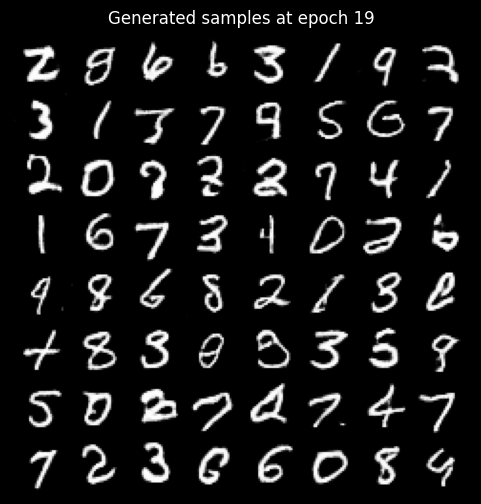

Epoch [20/30]  D_loss: 0.1560  G_loss: 2.9658


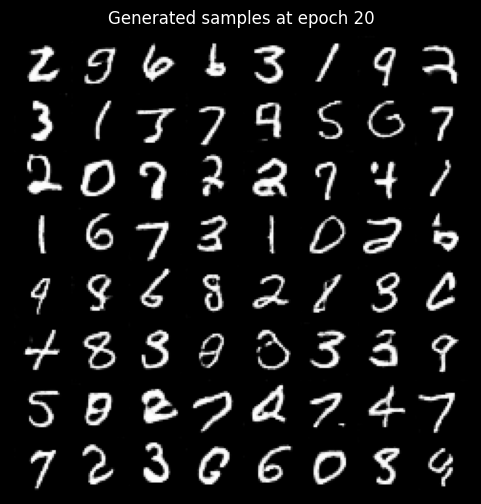

Epoch [21/30]  D_loss: 0.3157  G_loss: 1.7482


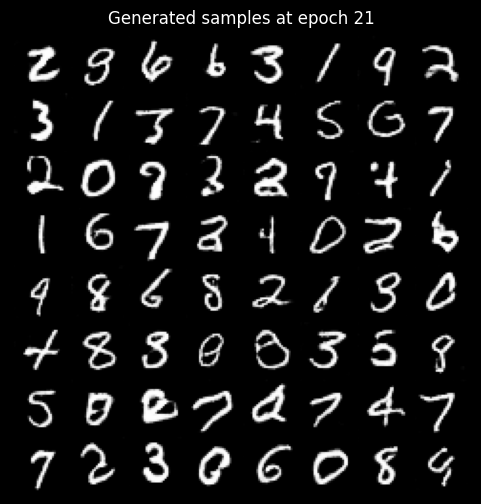

Epoch [22/30]  D_loss: 0.1727  G_loss: 2.4092


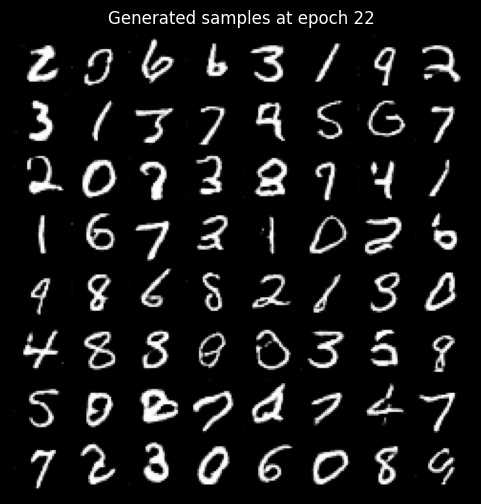

Epoch [23/30]  D_loss: 0.4435  G_loss: 2.9514


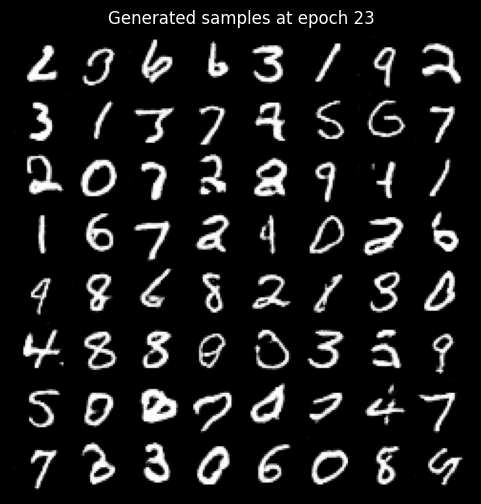

Epoch [24/30]  D_loss: 0.2013  G_loss: 1.5598


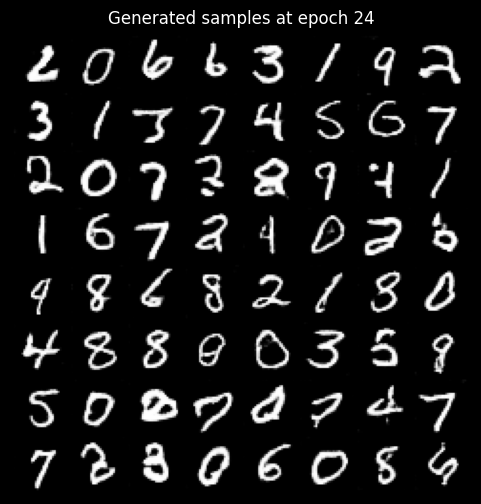

Epoch [25/30]  D_loss: 0.1146  G_loss: 3.8694


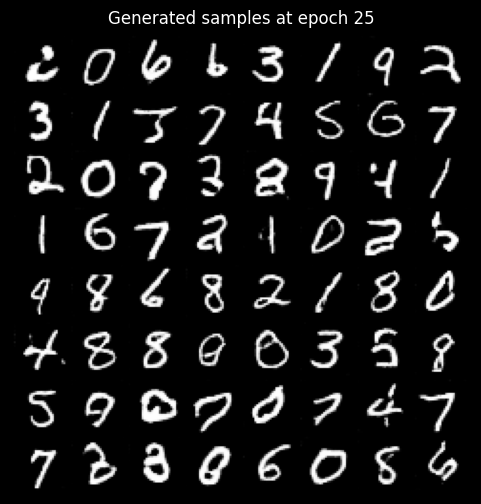

Epoch [26/30]  D_loss: 0.1712  G_loss: 2.4487


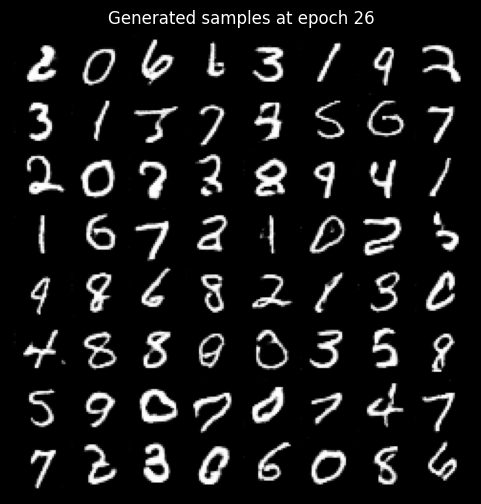

Epoch [27/30]  D_loss: 0.2662  G_loss: 2.8818


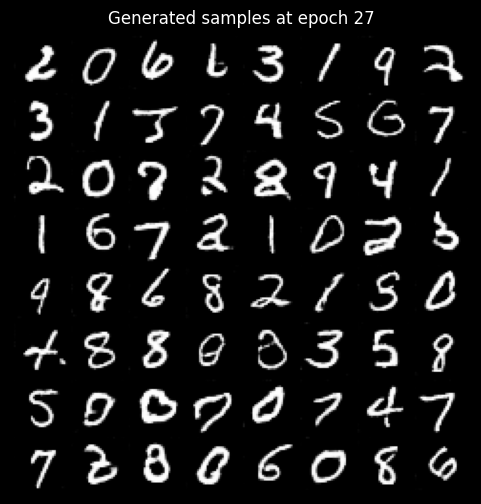

Epoch [28/30]  D_loss: 0.2456  G_loss: 3.9887


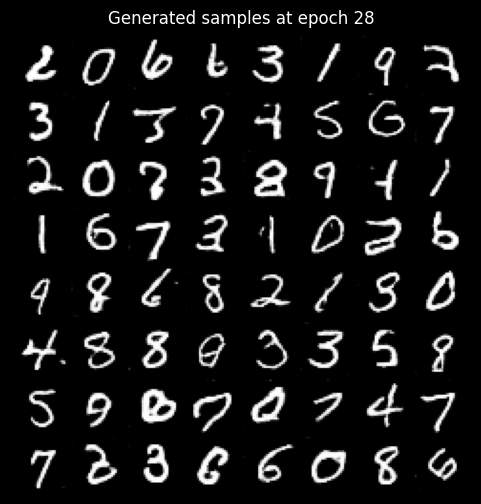

Epoch [29/30]  D_loss: 0.1770  G_loss: 3.5105


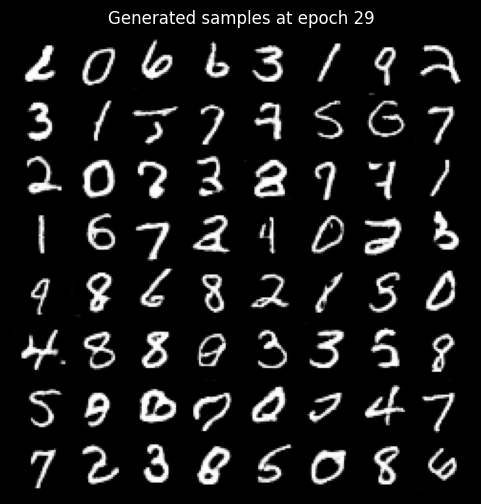

Epoch [30/30]  D_loss: 0.2053  G_loss: 5.1363


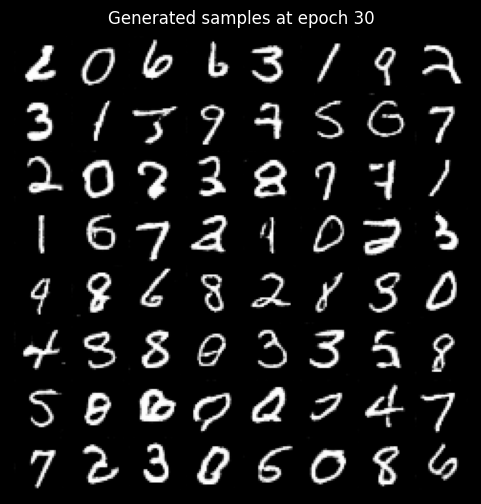

In [9]:
G.train()
D.train()

g_losses = []
d_losses = []

for epoch in range(1, num_epochs + 1):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)

        # --------------------
        #  Train Discriminator
        # --------------------
        optimizer_D.zero_grad()

        # Prepare real and fake labels for future train
        real_labels = torch.ones(real_imgs.size(0), 1, device=device) # array of 1s for the selected images
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device) # array of 0s for the to-be-generated images

        outputs_real = D(real_imgs)
        d_loss_real = criterion(outputs_real, real_labels)

        # Fake images
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = G(z) # generate from noise
        outputs_fake = D(fake_imgs) # what does the discriminator think?
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # ----------------
        #  Train Generator
        # ----------------
        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = G(z)
        outputs = D(fake_imgs)
        # Generator wants D to think fakes are real (label = 1)
        g_loss = criterion(outputs, real_labels)

        # backward and steps...
        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    # clear_output(wait=True)
    print(f"Epoch [{epoch}/{num_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")
    show_fake_samples(epoch, fixed_noise)

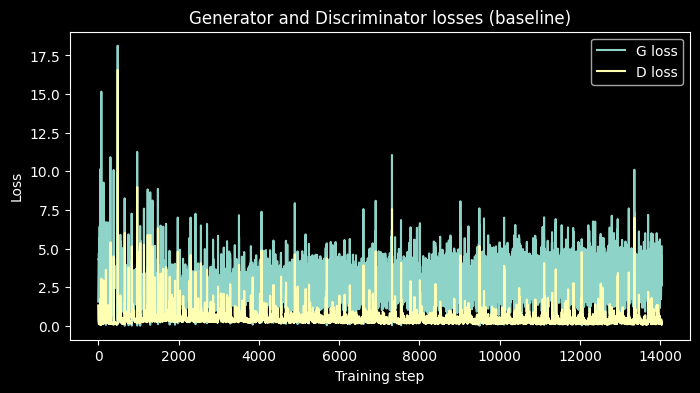

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(g_losses, label='G loss')
plt.plot(d_losses, label='D loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Generator and Discriminator losses (baseline)')
plt.legend()
plt.show()

In [11]:
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionV3Features(nn.Module):
    def __init__(self, device: torch.device):
        super().__init__()
        self.device = device
        inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        inception.eval()
        self.blocks = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        ).to(self.device)
        for param in self.blocks.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # If input is grayscale, repeat to 3 channels
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)

        x = (x + 1) / 2  # back to [0, 1]
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        # Inception normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
        x = (x - mean) / std

        features = self.blocks(x)
        return features.view(features.size(0), -1)

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def get_features(images, model, device, max_samples=1000):
    model.eval()
    features_list = []
    n_samples = 0

    if isinstance(images, DataLoader):
        for batch in images:
            if isinstance(batch, (list, tuple)):
                batch = batch[0]
            batch = batch.to(device)
            with torch.no_grad():
                feat = model(batch)
            features_list.append(feat.cpu().numpy())
            n_samples += batch.size(0)
            if n_samples >= max_samples:
                break
    else:
        images = images.to(device)
        with torch.no_grad():
            feat = model(images)
        features_list.append(feat.cpu().numpy())

    return np.concatenate(features_list, axis=0)[:max_samples]

# Initialize Inception model
inception_model = InceptionV3Features(device)

# 1. Compute statistics for real images
print("Computing statistics for real images...")
real_features = get_features(train_loader, inception_model, device, max_samples=1000)
mu_real = np.mean(real_features, axis=0)
sigma_real = np.cov(real_features, rowvar=False)

# 2. Generate fake images
print("Generating fake images for FID calculation...")
G.eval()
with torch.no_grad():
    z = torch.randn(1000, latent_dim, device=device)
    fake_imgs = G(z)

# 3. Compute statistics for fake images
print("Computing statistics for fake images...")
fake_features = get_features(fake_imgs, inception_model, device, max_samples=1000)
mu_fake = np.mean(fake_features, axis=0)
sigma_fake = np.cov(fake_features, rowvar=False)

# 4. Calculate FID score
fid_score = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID Score: {fid_score:.4f}")


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/andreipriboi/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:01<00:00, 107MB/s]  


Computing statistics for real images...
Generating fake images for FID calculation...
Computing statistics for fake images...


/var/folders/wz/c3crfx495cq6412hrdzsvv0r0000gn/T/ipykernel_12716/628900812.py:59: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


FID Score: 18.5026
